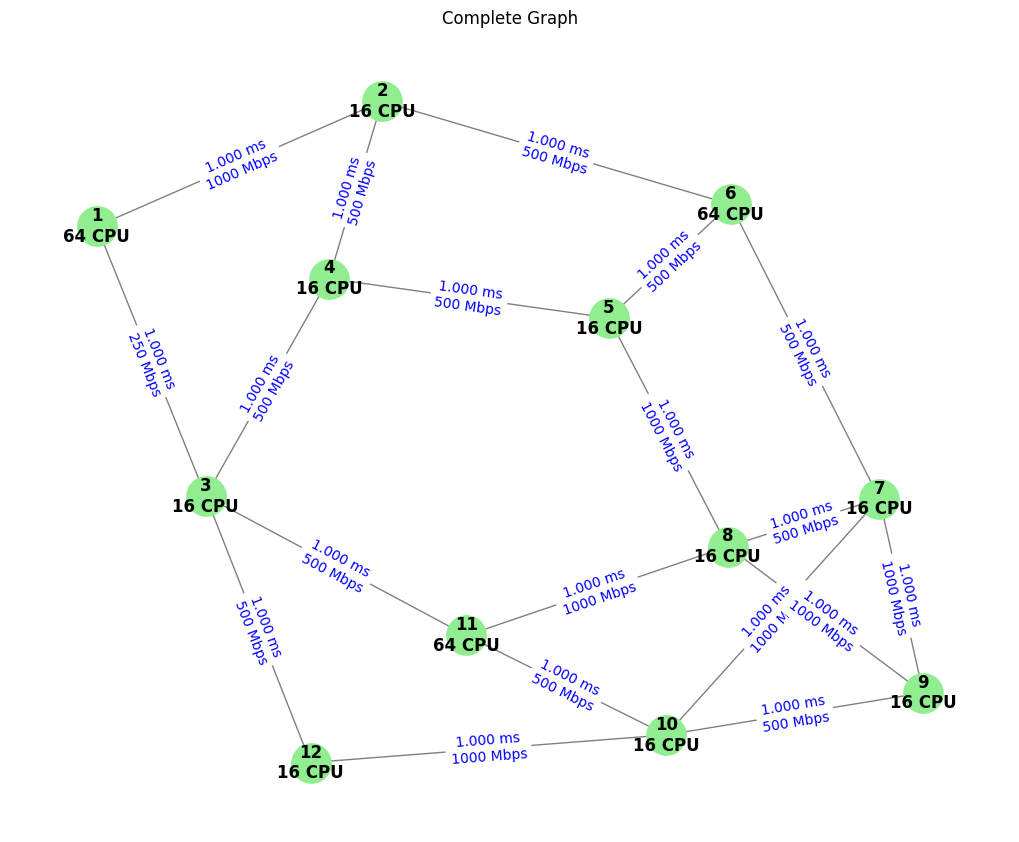

In [46]:
from topology import topology_bayern, draw_graph, topologie_finlande
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()
draw_graph(G)


In [57]:

# === Generate slices ===
vnf_profiles = [
    {"cpu": 2, "throughput": 140, "latency": 120},
    {"cpu": 4, "throughput": 150, "latency": 180},
    {"cpu": 6, "throughput": 160, "latency": 200},
    {"cpu": 8, "throughput": 175, "latency": 250}
]

slices = generate_random_slices(G, vnf_profiles, num_slices=20, num_vnfs_per_slice=3)

slices

[([{'id': 'vnf0_0', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 0},
   {'id': 'vnf0_1', 'cpu': 8, 'throughput': 175, 'latency': 250, 'slice': 0},
   {'id': 'vnf0_2', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 140, 'latency': 120},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 175, 'latency': 250}]),
 ([{'id': 'vnf1_0', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 1},
   {'id': 'vnf1_1', 'cpu': 6, 'throughput': 160, 'latency': 200, 'slice': 1},
   {'id': 'vnf1_2', 'cpu': 8, 'throughput': 175, 'latency': 250, 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 140, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 160, 'latency': 200}]),
 ([{'id': 'vnf2_0', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 2},
   {'id': 'vnf2_1', 'cpu': 4, 'throughput': 150, 'latency': 180, 'slice': 2},
   {'id': 'vnf2_2', 'cpu': 2, 'throughput': 140, 'latency': 120, 'slice': 2}],

In [58]:
# === Build MILP instance ===
from milp.formulation import MILPInstance
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi
import pandas as pd

# Create MILP instance directly from your topology and slices
instance = MILPInstance(G, slices)
print(instance)

# === Solve MILP with Gurobi ===
res = solve_gurobi(instance, msg=False)   # msg=False to suppress logs
print(f"Status: {res.status_str} | Objective: {res.objective:.4f}")

# === Adapt to heuristic-like format ===
milp_result = MILPResultAdapterGurobi(res, instance)

df_milp = pd.DataFrame([{
    "status": res.status_str,
    "objective": res.objective,
    "num_slices": len(instance.S),
    "num_vnfs": sum(len(instance.V_of_s[s]) for s in instance.S)
}])

print(milp_result)
print("Placed VNFs:", milp_result.placed_vnfs)
print("Routed VLs:", milp_result.routed_vls)


<MILPInstance | nodes=12 edges=19 slices=20 vnfs=60>
Status: 2 | Objective: 45.8250
<MILPResultAdapterGurobi placed=60 vls=80>
Placed VNFs: {'vnf0_0': 5, 'vnf0_1': 6, 'vnf0_2': 11, 'vnf1_0': 5, 'vnf1_1': 8, 'vnf1_2': 11, 'vnf2_0': 7, 'vnf2_1': 9, 'vnf2_2': 10, 'vnf3_0': 1, 'vnf3_1': 2, 'vnf3_2': 6, 'vnf4_0': 5, 'vnf4_1': 6, 'vnf4_2': 7, 'vnf5_0': 1, 'vnf5_1': 4, 'vnf5_2': 6, 'vnf6_0': 9, 'vnf6_1': 10, 'vnf6_2': 11, 'vnf7_0': 6, 'vnf7_1': 7, 'vnf7_2': 9, 'vnf8_0': 7, 'vnf8_1': 10, 'vnf8_2': 11, 'vnf9_0': 7, 'vnf9_1': 9, 'vnf9_2': 10, 'vnf10_0': 5, 'vnf10_1': 8, 'vnf10_2': 11, 'vnf11_0': 1, 'vnf11_1': 2, 'vnf11_2': 6, 'vnf12_0': 5, 'vnf12_1': 8, 'vnf12_2': 11, 'vnf13_0': 1, 'vnf13_1': 2, 'vnf13_2': 6, 'vnf14_0': 3, 'vnf14_1': 4, 'vnf14_2': 11, 'vnf15_0': 5, 'vnf15_1': 8, 'vnf15_2': 11, 'vnf16_0': 1, 'vnf16_1': 2, 'vnf16_2': 4, 'vnf17_0': 5, 'vnf17_1': 8, 'vnf17_2': 11, 'vnf18_0': 1, 'vnf18_1': 3, 'vnf18_2': 4, 'vnf19_0': 1, 'vnf19_1': 4, 'vnf19_2': 11}
Routed VLs: {(0, ('vnf0_0', 'vnf0_1

In [59]:
def print_solution_gurobi(res, instance, eps=1e-6):
    """
    Pretty-print MILP solution from Gurobi result.
    Works with GurobiSolveResult (res.values dict).
    """
    print("=== MILP Solution (Gurobi) ===")
    if res.objective is not None:
        print(f"Objective value: {res.objective:.3f}")
    else:
        print("Objective value: None (no optimal solution)")
    print(f"Status: {res.status_str}\n")

    vals = res.values

    # -------- VNF allocations (argmax over nodes) --------
    print("VNF allocations:")
    placed = {}
    for s in instance.S:
        for i in instance.V_of_s[s]:
            candidates = [(n, vals.get(("v", i, n), 0.0) or 0.0) for n in instance.N]
            n_star, v_star = max(candidates, key=lambda t: t[1])
            placed[i] = (n_star, v_star)
            print(f"  - {i} -> Node {n_star}  (value={v_star:.3f}, sum={sum(v for _, v in candidates):.3f})")

    # -------- Virtual Links (flows f[e,s,(i,j)]) --------
    print("\nVirtual Link allocations:")
    for s in instance.S:
        vnf_ids = instance.V_of_s[s]
        for q in range(len(vnf_ids) - 1):
            i, j = vnf_ids[q], vnf_ids[q + 1]
            used_edges = []
            for e in instance.E:
                val = vals.get(("f", e, s, (i, j)), 0.0) or 0.0
                if val > 0.5 - eps:
                    used_edges.append(e)
            if used_edges:
                print(f"  - Slice {s}, VL ({i}->{j}) uses edges: {used_edges}")
            else:
                print(f"  - Slice {s}, VL ({i}->{j}) NOT routed")

    # -------- Node utilization --------
    print("\nNode utilization:")
    for n in instance.N:
        u_val = vals.get(("u", n), 0.0) or 0.0
        z_val = vals.get(("z", n), 0.0) or 0.0
        print(f"  - Node {n}: u={u_val:.2f}, z={int(round(z_val))}")

    # -------- Link utilization --------
    print("\nLink utilization:")
    for e in instance.E:
        rho_val = vals.get(("rho", e), 0.0) or 0.0
        w_val = vals.get(("w", e), 0.0) or 0.0
        if rho_val > eps or w_val > 0.5 - eps:
            print(f"  - Link {e}: rho={rho_val:.2f}, w={int(round(w_val))}")


In [60]:
instance = MILPInstance(G, slices)
res = solve_gurobi(instance, msg=False)
print_solution_gurobi(res, instance)

print("=== Debug MILP Variables ===")
count_f = 0
for key, val in res.values.items():
    if isinstance(key, tuple) and len(key) == 4 and key[0] == "f" and val > 0.5:
        print(key, "=", val)
        count_f += 1
        if count_f > 20:  # não imprimir tudo
            break
print(f"Total f variables active: {count_f}")

=== MILP Solution (Gurobi) ===
Objective value: 45.825
Status: 2

VNF allocations:
  - vnf0_0 -> Node 5  (value=1.000, sum=1.000)
  - vnf0_1 -> Node 6  (value=1.000, sum=1.000)
  - vnf0_2 -> Node 11  (value=1.000, sum=1.000)
  - vnf1_0 -> Node 5  (value=1.000, sum=1.000)
  - vnf1_1 -> Node 8  (value=1.000, sum=1.000)
  - vnf1_2 -> Node 11  (value=1.000, sum=1.000)
  - vnf2_0 -> Node 7  (value=1.000, sum=1.000)
  - vnf2_1 -> Node 9  (value=1.000, sum=1.000)
  - vnf2_2 -> Node 10  (value=1.000, sum=1.000)
  - vnf3_0 -> Node 1  (value=1.000, sum=1.000)
  - vnf3_1 -> Node 2  (value=1.000, sum=1.000)
  - vnf3_2 -> Node 6  (value=1.000, sum=1.000)
  - vnf4_0 -> Node 5  (value=1.000, sum=1.000)
  - vnf4_1 -> Node 6  (value=1.000, sum=1.000)
  - vnf4_2 -> Node 7  (value=1.000, sum=1.000)
  - vnf5_0 -> Node 1  (value=1.000, sum=1.000)
  - vnf5_1 -> Node 4  (value=1.000, sum=1.000)
  - vnf5_2 -> Node 6  (value=1.000, sum=1.000)
  - vnf6_0 -> Node 9  (value=1.000, sum=1.000)
  - vnf6_1 -> Node 10

In [61]:
node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}
link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})
link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})



In [62]:

from a_star import run_astar
from run_abo_full_batch import run_abo_full_batch
from run_fabo_full_batch import run_fabo_full_batch
from first_fit import run_first_fit
from best_fit import run_best_fit
from copy import deepcopy


In [63]:

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency ,link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)


df_astar
df_abo
df_fabo
df_bestfit


[INFO][A*] === Solving slice 1 with 3 VNFs and 2 VLs ===
[INFO][A*] Placed vnf0_0 on node 1 (use=2, remaining=62).
[INFO][A*] Placed vnf0_0 on node 6 (use=2, remaining=62).
[INFO][A*] Placed vnf0_0 on node 11 (use=2, remaining=62).
[INFO][A*] Placed vnf0_0 on node 2 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 3 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 4 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 5 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 7 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 8 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 9 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 10 (use=2, remaining=14).
[INFO][A*] Placed vnf0_0 on node 12 (use=2, remaining=14).
[INFO][A*] Placed vnf0_1 on node 6 (use=8, remaining=56).
[INFO][A*] Placed vnf0_1 on node 11 (use=8, remaining=56).
[DEBUG][A*] Anti-affinity: vnf0_1 cannot be placed on node 1 (another VNF of slice 0 already there).
[INFO][A*] Placed vnf0_1 

slice  accepted  g_cost
0       1      True     3.0
1       2      True     2.0
2       3      True     2.0
3       4      True     2.0
4       5      True     4.0
5       6      True     2.0
6       7      True     2.0
7       8      True     3.0
8       9      True     2.0
9      10      True     2.0
10     11      True     4.0
11     12      True     5.0
12     13     False     NaN
13     14     False     NaN
14     15     False     NaN
15     16     False     NaN
16     17     False     NaN
17     18     False     NaN
18     19     False     NaN
19     20     False     NaN

In [64]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

# monta a instância como antes
# instance = MILPInstance(G, slices)

# === Resolve MILP com Gurobi ===
res = solve_gurobi(instance, msg=True)   # msg=False se quiser ocultar o log
print("Status:", res.status_str, " Objective:", res.objective)

# === Adapta para formato compatível com heurísticas ===
milp_result = MILPResultAdapterGurobi(res, instance)

# === Integra nas métricas ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "First Fit": ff_results,
    "Best-fit": bestfit_results,
    "MILP (Gurobi)": [milp_result],
}

# o loop de métricas (compute_energy_*) continua funcionando normalmente


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 913 rows, 1542 columns and 7733 nonzeros
Model fingerprint: 0x616051f2
Variable types: 31 continuous, 1511 integer (1511 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 202 rows and 391 columns
Presolve time: 0.03s
Presolved: 711 rows, 1151 columns, 4471 nonzeros
Variable types: 0 continuous, 1151 integer (1151 binary)

Root relaxation: objective 2.858572e+01, 922 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

In [65]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution_gurobi(G, res, instance):
    """
    Visualize MILP solution (Gurobi).
    - Active nodes in green, inactive in gray
    - Node labels show VNFs placed
    - Active links highlighted in red
    """
    pos = nx.spring_layout(G, seed=42)
    vals = res.values

    # --- Collect VNFs placed on each node ---
    vnfs_per_node = {n: [] for n in instance.N}
    active_nodes = set()

    for s in instance.S:
        for i in instance.V_of_s[s]:
            for n in instance.N:
                if vals.get(("v", i, n), 0.0) > 0.5:
                    vnfs_per_node[n].append(i)

    for n in instance.N:
        if vals.get(("z", n), 0.0) > 0.5:
            active_nodes.add(n)

    # --- Node colors ---
    node_colors = ["lightgreen" if n in active_nodes else "lightgray" for n in G.nodes()]

    # --- Draw base graph ---
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=False)

    # --- Node labels: node id + VNFs placed ---
    labels = {}
    for n in G.nodes():
        if vnfs_per_node[n]:
            labels[n] = f"{n}\n" + ",".join(vnfs_per_node[n])
        else:
            labels[n] = str(n)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # --- Highlight active links (w[e] = 1) ---
    active_edges = []
    for e in instance.E:
        if vals.get(("w", e), 0.0) > 0.5:
            active_edges.append(e)
    nx.draw_networkx_edges(G, pos, edgelist=active_edges, edge_color="red", width=2)

    plt.title("MILP Solution (Gurobi)")
    plt.show()


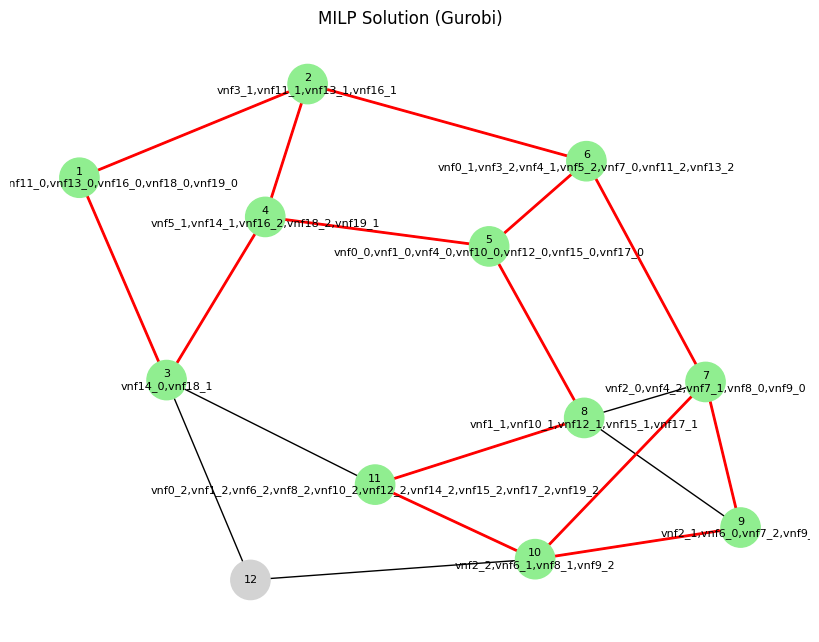

In [66]:
instance = MILPInstance(G, slices)
res = solve_gurobi(instance, msg=False)
plot_solution_gurobi(G, res, instance)

In [67]:
def _is_vl_routed(result, slice_idx, src, dst):
    """
    Check if a VL (src->dst) is routed in 'result', accepting different key styles:
    - (src, dst)
    - (dst, src)                # reversed order
    - (slice_idx, (src, dst))
    - (slice_idx, (dst, src))
    Accepts either a path (list of nodes) or a list of edges (u,v).
    Works with both CBC and Gurobi adapters.
    """
    if not result or not getattr(result, "routed_vls", None):
        return False

    # direct heuristic keys
    if (src, dst) in result.routed_vls:
        val = result.routed_vls[(src, dst)]
        return bool(val)
    if (dst, src) in result.routed_vls:
        val = result.routed_vls[(dst, src)]
        return bool(val)

    # MILP adapter style
    key1 = (slice_idx, (src, dst))
    key2 = (slice_idx, (dst, src))
    if key1 in result.routed_vls:
        return bool(result.routed_vls[key1])
    if key2 in result.routed_vls:
        return bool(result.routed_vls[key2])

    return False


In [68]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=True):
    """
    Count how many slices are successfully accepted.

    A slice is considered accepted if:
      - all its VNFs are placed
      - all its Virtual Links (VLs) are routed

    Compatible with:
      - heuristic results
      - MILP (CBC) results
      - MILP (Gurobi) results
    """
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            if verbose:
                print(f"[Slice {s_idx}] REJECTED: missing placed_vnfs or routed_vls")
            continue

        vnfs, vls = slices[s_idx]

        # --- Check VNF placement ---
        placed_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not placed_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Slice {s_idx}] REJECTED: missing VNFs {missing}")
            continue

        # --- Check VL routing ---
        vls_ok = True
        for vl in vls:
            src, dst = vl["from"], vl["to"]

            if (src, dst) in result.routed_vls or (dst, src) in result.routed_vls:
                continue
            elif (s_idx, (src, dst)) in result.routed_vls or (s_idx, (dst, src)) in result.routed_vls:
                continue
            else:
                vls_ok = False
                if verbose:
                    print(f"[Slice {s_idx}] REJECTED: VL ({src}->{dst}) not routed")
                break

        if vls_ok:
            accepted += 1
            if verbose:
                print(f"[Slice {s_idx}] ACCEPTED ✓ (all VNFs placed, all VLs routed)")

    if verbose:
        print(f"\nTotal slices accepted: {accepted}/{len(slices)}")
    return accepted


In [69]:
print("=== Sanity check for all methods ===")
for method_name, result_list in method_results.items():
    if not result_list:
        continue
    print(f"\n--- {method_name} ---")
    count_accepted_slices(result_list, slices, verbose=True)



=== Sanity check for all methods ===

--- A* ---
[Slice 0] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 1] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 2] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 3] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 4] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 5] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 6] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 7] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 8] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 9] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 10] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 11] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 12] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 13] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 14] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 15] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 16] ACCEPTED ✓ (all VNFs placed, all VLs routed)
[Slice 17

In [70]:
def sanity_check_milp_gurobi(res, instance, slices, eps=1e-6):
    """
    Sanity check for MILP (Gurobi) results.
    Prints node CPU usage, slice acceptance, and routing correctness.
    Compatible with GurobiSolveResult.
    """
    print("=== Sanity check MILP (Gurobi) ===")
    if res.objective is not None:
        print(f"Objective value: {res.objective:.3f}")
    else:
        print("Objective value: None (no optimal solution)")
    print(f"Status: {res.status_str}")

    var_dict = res.values  # dict: keys are tuples like ('v', i, n), ('f', e, s, (i,j)), etc.

    # --- CPU usage per node ---
    cpu_used = {n: 0 for n in instance.N}
    for key, value in var_dict.items():
        if not isinstance(key, tuple):
            continue
        if key[0] == "v" and value > 0.5:
            _, i, n = key
            cpu_used[n] += instance.CPU_i[i]

    print("\nNode CPU usage:")
    for n in instance.N:
        used = cpu_used[n]
        cap = instance.CPU_cap[n]
        warn = "⚠️" if used > cap + eps else ""
        print(f"  Node {n}: used {used} / cap {cap} {warn}")

    # --- Slice acceptance check ---
    accepted = 0
    for s in instance.S:
        vnfs, vls = slices[s]
        ok = True
        print(f"\n[Slice {s}]")

        # VNFs
        for v in vnfs:
            i = v["id"]
            assigned_nodes = [
                n for n in instance.N
                if ("v", i, n) in var_dict and var_dict[("v", i, n)] > 0.5
            ]
            if assigned_nodes:
                print(f"  VNF {i} -> {assigned_nodes}")
            else:
                print(f"  VNF {i} NOT allocated")
                ok = False

        # VLs
        for vl in vls:
            i, j = vl["from"], vl["to"]
            used_edges = []
            for key, value in var_dict.items():
                if not isinstance(key, tuple):
                    continue
                if key[0] == "f" and value > 0.5:
                    _, e, s_idx, (src, dst) = key
                    if s_idx == s and {src, dst} == {i, j}:
                        used_edges.append(e)
            if used_edges:
                print(f"  VL ({i}->{j}) routed via {used_edges}")
            else:
                print(f"  VL ({i}->{j}) NOT routed")
                ok = False

        if ok:
            print(f"  -> Slice {s} ACCEPTED ✓")
            accepted += 1
        else:
            print(f"  -> Slice {s} REJECTED ✗")

    print(f"\nTotal slices accepted: {accepted}/{len(instance.S)}")


In [71]:
print(type(res))
print(dir(res))


<class 'milp.solver_gurobi.GurobiSolveResult'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'objective', 'status_code', 'status_str', 'values']


In [72]:
sanity_check_milp_gurobi(res, instance, slices)

=== Sanity check MILP (Gurobi) ===
Objective value: 45.825
Status: 2

Node CPU usage:
  Node 1: used 48 / cap 64 
  Node 2: used 16 / cap 16 
  Node 3: used 14 / cap 16 
  Node 4: used 16 / cap 16 
  Node 5: used 16 / cap 16 
  Node 6: used 36 / cap 64 
  Node 7: used 16 / cap 16 
  Node 8: used 16 / cap 16 
  Node 9: used 16 / cap 16 
  Node 10: used 16 / cap 16 
  Node 11: used 60 / cap 64 
  Node 12: used 0 / cap 16 

[Slice 0]
  VNF vnf0_0 -> [5]
  VNF vnf0_1 -> [6]
  VNF vnf0_2 -> [11]
  VL (vnf0_0->vnf0_1) routed via [(5, 6)]
  VL (vnf0_1->vnf0_2) routed via [(6, 7), (7, 10), (10, 11)]
  -> Slice 0 ACCEPTED ✓

[Slice 1]
  VNF vnf1_0 -> [5]
  VNF vnf1_1 -> [8]
  VNF vnf1_2 -> [11]
  VL (vnf1_0->vnf1_1) routed via [(5, 8)]
  VL (vnf1_1->vnf1_2) routed via [(8, 11)]
  -> Slice 1 ACCEPTED ✓

[Slice 2]
  VNF vnf2_0 -> [7]
  VNF vnf2_1 -> [9]
  VNF vnf2_2 -> [10]
  VL (vnf2_0->vnf2_1) routed via [(7, 9)]
  VL (vnf2_1->vnf2_2) routed via [(9, 10)]
  -> Slice 2 ACCEPTED ✓

[Slice 3]
  VN

In [73]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=False):
    """
    Count accepted slices across different result types:
      - All VNFs placed
      - All VLs routed

    Handles:
      (A) Heuristics → list with one result per slice (has .placed_vnfs / .routed_vls)
      (B) MILP adapter (CBC or Gurobi) → single aggregated result with routed_vls keys like (s_idx, (src, dst))
      (C) Raw solver result (PulpSolveResult or GurobiSolveResult) → single result with .values dict
    """
    if not results:
        return 0

    # --- Helper: check routed VL presence with multiple key styles
    def _vl_present(routed_vls, s_idx, src, dst):
        """Check several key conventions: (src,dst), (dst,src), (s,(src,dst)), (s,(dst,src))."""
        if (src, dst) in routed_vls or (dst, src) in routed_vls:
            return True
        key1 = (s_idx, (src, dst))
        key2 = (s_idx, (dst, src))
        return key1 in routed_vls or key2 in routed_vls

    # ----------------------
    # Case C: raw solver result (PuLP or Gurobi)
    # ----------------------
    r0 = results[0]
    if hasattr(r0, "values"):  # works for PulpSolveResult or GurobiSolveResult
        var_dict = r0.values
        accepted = 0
        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            # --- VNFs placed ---
            vnfs_ok = True
            for v in vnfs:
                i = v["id"]
                assigned = any(
                    isinstance(k, tuple) and k[0] == "v" and k[1] == i and val > 0.5
                    for k, val in var_dict.items()
                )
                if not assigned:
                    vnfs_ok = False
                    if verbose:
                        print(f"[MILP raw] slice {s_idx}: VNF {i} not allocated")
                    break

            # --- VLs routed ---
            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    routed = any(
                        isinstance(k, tuple)
                        and k[0] == "f"
                        and k[2] == s_idx
                        and set(k[3]) == {src, dst}
                        and val > 0.5
                        for k, val in var_dict.items()
                    )
                    if not routed:
                        vls_ok = False
                        if verbose:
                            print(f"[MILP raw] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP raw] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP raw): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case B: MILP adapter (CBC or Gurobi)
    # ----------------------
    is_milp_adapter = (
        len(results) == 1
        and hasattr(r0, "routed_vls")
        and any(isinstance(k, tuple) and len(k) >= 2 and isinstance(k[0], int)
                for k in r0.routed_vls.keys())
    )
    if is_milp_adapter:
        accepted = 0
        placed_vnfs = getattr(r0, "placed_vnfs", {})
        routed_vls = getattr(r0, "routed_vls", {})

        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]
            vnfs_ok = all(v["id"] in placed_vnfs for v in vnfs)

            if not vnfs_ok and verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in placed_vnfs]
                print(f"[MILP adapter] slice {s_idx}: missing VNFs {missing}")

            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    if not _vl_present(routed_vls, s_idx, src, dst):
                        vls_ok = False
                        if verbose:
                            print(f"[MILP adapter] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP adapter] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP adapter): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case A: heuristics (one result per slice)
    # ----------------------
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            continue
        vnfs, vls = slices[s_idx]

        vnfs_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not vnfs_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Heuristic] slice {s_idx}: missing VNFs {missing}")
            continue

        vls_ok = all(
            (vl["from"], vl["to"]) in result.routed_vls or (vl["to"], vl["from"]) in result.routed_vls
            for vl in vls
        )
        if not vls_ok and verbose:
            missing = [
                (vl["from"], vl["to"]) for vl in vls
                if (vl["from"], vl["to"]) not in result.routed_vls
                and (vl["to"], vl["from"]) not in result.routed_vls
            ]
            print(f"[Heuristic] slice {s_idx}: missing VLs {missing}")

        if vnfs_ok and vls_ok:
            accepted += 1
            if verbose:
                print(f"[Heuristic] slice {s_idx}: ACCEPTED ✓")

    if verbose:
        print(f"Total slices accepted (heuristics): {accepted}/{len(results)}")
    return accepted


In [74]:
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new,
    compute_milp_bandwidth_latency
)

comparison_rows = []

for method_name, result_list in method_results.items():
    if not result_list:
        continue

    # --- Energy metrics ---
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices, node_capacity_base)
    normalized_energy = compute_energy_new(result_list, slices, node_capacity_base, link_capacity_base)

    # --- Bandwidth & Latency ---
    if "MILP" in method_name and len(result_list) == 1:
        
        total_bw, total_lat, _, _ = compute_milp_bandwidth_latency(res, instance)
    else:
        total_bw_list = compute_total_bandwidth(result_list, slices)
        total_lat_list = compute_total_latency(result_list, link_latency)
        total_bw = sum(b for b in total_bw_list if b is not None)
        total_lat = sum(l for l in total_lat_list if l is not None)

    # --- Build comparison row ---
    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices, verbose=False),
        "Total Bandwidth": total_bw,
        "Total Latency": total_lat,
        "Total Energy": normalized_energy
    })

# --- Final DataFrame ---
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)


[MILP] Total bandwidth used across all links: 6980.0
[MILP] Total latency across all slices: 49.0


Method  Slices Accepted  Total Bandwidth  Total Latency  \
0             A*               20           7095.0           46.0   
1            ABO               20           7665.0           50.0   
2           FABO               16           5580.0           36.0   
3      First Fit               20          10640.0           69.0   
4       Best-fit               12           5095.0           33.0   
5  MILP (Gurobi)               20           6980.0           49.0   

   Total Energy  
0      22.50000  
1      22.96875  
2      22.12500  
3      22.50000  
4      20.31250  
5      21.12500

In [75]:
print("MILP routed_vls keys:", list(milp_result.routed_vls.keys()))


MILP routed_vls keys: [(0, ('vnf0_0', 'vnf0_1')), ('vnf0_0', 'vnf0_1'), (0, ('vnf0_1', 'vnf0_2')), ('vnf0_1', 'vnf0_2'), (1, ('vnf1_0', 'vnf1_1')), ('vnf1_0', 'vnf1_1'), (1, ('vnf1_1', 'vnf1_2')), ('vnf1_1', 'vnf1_2'), (2, ('vnf2_0', 'vnf2_1')), ('vnf2_0', 'vnf2_1'), (2, ('vnf2_1', 'vnf2_2')), ('vnf2_1', 'vnf2_2'), (3, ('vnf3_0', 'vnf3_1')), ('vnf3_0', 'vnf3_1'), (3, ('vnf3_1', 'vnf3_2')), ('vnf3_1', 'vnf3_2'), (4, ('vnf4_0', 'vnf4_1')), ('vnf4_0', 'vnf4_1'), (4, ('vnf4_1', 'vnf4_2')), ('vnf4_1', 'vnf4_2'), (5, ('vnf5_0', 'vnf5_1')), ('vnf5_0', 'vnf5_1'), (5, ('vnf5_1', 'vnf5_2')), ('vnf5_1', 'vnf5_2'), (6, ('vnf6_0', 'vnf6_1')), ('vnf6_0', 'vnf6_1'), (6, ('vnf6_1', 'vnf6_2')), ('vnf6_1', 'vnf6_2'), (7, ('vnf7_0', 'vnf7_1')), ('vnf7_0', 'vnf7_1'), (7, ('vnf7_1', 'vnf7_2')), ('vnf7_1', 'vnf7_2'), (8, ('vnf8_0', 'vnf8_1')), ('vnf8_0', 'vnf8_1'), (8, ('vnf8_1', 'vnf8_2')), ('vnf8_1', 'vnf8_2'), (9, ('vnf9_0', 'vnf9_1')), ('vnf9_0', 'vnf9_1'), (9, ('vnf9_1', 'vnf9_2')), ('vnf9_1', 'vnf9_2'

In [76]:
import matplotlib.pyplot as plt
import os

def plot_cpu_usage(G, slices, method_results, results_dir):
    node_capacity = {n: G.nodes[n]["cpu"] for n in G.nodes}
    nodes = list(node_capacity.keys())

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.12
    colors = plt.cm.Set2.colors
    methods = list(method_results.keys())

    for idx, (method_name, result_list) in enumerate(method_results.items()):
        if not result_list:
            continue

        used_cpu = {n: 0 for n in nodes}

        # --- MILP special case ---
        if method_name.startswith("MILP"):
            milp_res = result_list[0]
            if hasattr(milp_res, "placed_vnfs"):
                for vnf_id, n in milp_res.placed_vnfs.items():
                    try:
                        vnf_cpu = next(vnf["cpu"] for s in slices for vnf in s[0] if vnf["id"] == vnf_id)
                        used_cpu[n] += vnf_cpu
                    except StopIteration:
                        continue
        else:
            for r in result_list:
                if r is None or not hasattr(r, "placed_vnfs"):
                    continue
                for vnf_id, n in r.placed_vnfs.items():
                    try:
                        vnf_cpu = next(vnf["cpu"] for s in slices for vnf in s[0] if vnf["id"] == vnf_id)
                        used_cpu[n] += vnf_cpu
                    except StopIteration:
                        continue

        # --- Plot bars ---
        usage = [used_cpu[n] for n in nodes]
        offset = (idx - len(methods) / 2) * bar_width
        positions = [i + offset for i in range(len(nodes))]
        ax.bar(positions, usage, width=bar_width, label=method_name, color=colors[idx % len(colors)])

    # --- Labels and layout ---
    ax.set_title("CPU Utilization per Node")
    ax.set_xlabel("Nodes")
    ax.set_ylabel("CPU (units)")
    ax.set_xticks(range(len(nodes)))
    ax.set_xticklabels(nodes)
    ax.legend()
    plt.grid(axis="y")

    # --- Save instead of show ---
    output_path = os.path.join(results_dir, "cpu_utilization.png")
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"[INFO] Saved CPU utilization chart to {output_path}")



In [77]:
# ==============================
# Pretty-print MILP objective
# Works with:
#  - PulpSolveResult (CBC)  -> res.values: dict with keys like ('u', n), ('z', n), ('rho', e), ('w', e)
#  - SciPy (milp / linprog) -> pass (res, var_index) instead of res.values (see second wrapper)
# ==============================

def latex_name(var):
    """Return a LaTeX-friendly variable name from our tuple key."""
    kind = var[0]
    if kind in ("u", "z"):         # ('u', n)
        return f"{kind}_{{{var[1]}}}"
    if kind in ("rho", "w"):       # ('rho', (i,j))
        i, j = var[1]
        return f"{kind}_{{({i},{j})}}"
    if kind == "v":                # ('v', vnf_id, n)
        return f"v_{{{var[1]},{var[2]}}}"
    if kind == "f":                # ('f', (i,j), s, (src,dst))
        (a,b), s, (src,dst) = var[1], var[2], var[3]
        return f"f_{{({a},{b}),s={s},({src}\\to{dst})}}"
    return str(var)

def objective_to_latex_from_values(instance, values_dict, eps=1e-12):
    """
    Build symbolic and numeric LaTeX for:
        E_total = sum_n (u_n + z_n) + sum_e (rho_e + w_e)
    values_dict: dict mapping tuple keys to floats (e.g., from PulpSolveResult.values)
    """
    # Collect terms
    node_terms = []     # (latex_name, value)
    link_terms = []
    node_val_sum = 0.0
    link_val_sum = 0.0

    # Node side: u_n + z_n
    for n in instance.N:
        u_key = ("u", n)
        z_key = ("z", n)
        u_val = float(values_dict.get(u_key, 0.0))
        z_val = float(values_dict.get(z_key, 0.0))
        node_terms.append( (latex_name(u_key), u_val) )
        node_terms.append( (latex_name(z_key), z_val) )
        node_val_sum += u_val + z_val

    # Link side: rho_e + w_e
    for e in instance.E:
        rho_key = ("rho", e)
        w_key   = ("w", e)
        rho_val = float(values_dict.get(rho_key, 0.0))
        w_val   = float(values_dict.get(w_key, 0.0))
        link_terms.append( (latex_name(rho_key), rho_val) )
        link_terms.append( (latex_name(w_key),   w_val) )
        link_val_sum += rho_val + w_val

    total = node_val_sum + link_val_sum

    # Build symbolic latex
    nodes_sym = " + ".join([f"{nm}" for nm,_ in node_terms]) if node_terms else "0"
    links_sym = " + ".join([f"{nm}" for nm,_ in link_terms]) if link_terms else "0"
    symbolic = (
        r"E_{\text{total}} = \sum_{n\in N}(u_n + z_n) + \sum_{e\in E}(\rho_e + w_e)"
        + r" \;=\; (" + nodes_sym + r") \;+\; (" + links_sym + r")"
    )

    # Build numeric latex with substitution
    nodes_num = " + ".join([f"{nm}={val:.3f}" for nm,val in node_terms if abs(val)>eps]) or "0"
    links_num = " + ".join([f"{nm}={val:.3f}" for nm,val in link_terms if abs(val)>eps]) or "0"
    numeric = (
        r"E_{\text{total}} = (" + nodes_num + r") \;+\; (" + links_num + r")"
        + rf" \;=\; {node_val_sum:.3f} + {link_val_sum:.3f} \;=\; \boxed{{{total:.3f}}}"
    )

    return symbolic, numeric, {
        "node_sum": node_val_sum,
        "link_sum": link_val_sum,
        "total": total
    }

def print_objective_expression_milp(res, instance):
    """Convenience printer for PulpSolveResult (CBC)."""
    values_dict = res.values  # expects tuple-keyed dict
    sym, num, parts = objective_to_latex_from_values(instance, values_dict)
    print("=== Objective (symbolic) ===")
    print(sym)
    print("\n=== Objective (with values) ===")
    print(num)
    print(f"\n[Decomposition] nodes={parts['node_sum']:.3f}  links={parts['link_sum']:.3f}  total={parts['total']:.3f}")

# --- If you also want to support SciPy results (res, var_index) ---
def values_from_scipy(res, var_index):
    """Convert SciPy (res, var_index) into the same tuple-keyed dict used above."""
    out = {}
    for key, idx in var_index.items():
        out[key] = float(res.x[idx])
    return out

def print_objective_expression_scipy(res, var_index, instance):
    values_dict = values_from_scipy(res, var_index)
    sym, num, parts = objective_to_latex_from_values(instance, values_dict)
    print("=== Objective (symbolic) ===")
    print(sym)
    print("\n=== Objective (with values) ===")
    print(num)
    print(f"\n[Decomposition] nodes={parts['node_sum']:.3f}  links={parts['link_sum']:.3f}  total={parts['total']:.3f}")


In [78]:
import os
from datetime import datetime

def create_simulation_folder(base_dir="results"):
    """
    Create a new timestamped folder inside base_dir to store simulation outputs.
    Example: results/2025-10-13_21-45-02/
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    sim_dir = os.path.join(base_dir, timestamp)
    os.makedirs(sim_dir, exist_ok=True)
    print(f"[INFO] Simulation folder created: {sim_dir}")
    return sim_dir


In [79]:
results_dir = create_simulation_folder()


[INFO] Simulation folder created: results/2025-10-14_15-57-50


In [80]:
num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)

summary_info = {
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
    "num_slices": [num_slices],
    "num_vnfs_total": [num_vnfs_total]
}

import pandas as pd
df_info = pd.DataFrame(summary_info)
df_info.to_csv(f"{results_dir}/experiment_info.csv", index=False)
df_astar.to_csv(f"{results_dir}/astar_results.csv", index=False)
df_abo.to_csv(f"{results_dir}/abo_results.csv", index=False)
df_fabo.to_csv(f"{results_dir}/fabo_results.csv", index=False)
df_bestfit.to_csv(f"{results_dir}/bestfit_results.csv", index=False)
df_ff.to_csv(f"{results_dir}/ff_results.csv", index=False)
df_milp.to_csv(f"{results_dir}/milp_results.csv", index=False)
df_metrics.to_csv(f"{results_dir}/metrics.csv", index=False)


In [81]:
with open(f"{results_dir}/log.txt", "w") as f:
    f.write(f"Experiment timestamp: {datetime.now()}\n")
    f.write(f"Number of slices: {num_slices}\n")
    f.write(f"Number of VNFs: {num_vnfs_total}\n")
    f.write("\n=== Summary ===\n")
    f.write(df_astar.to_string(index=False))
    f.write(df_abo.to_string(index=False))
    f.write(df_fabo.to_string(index=False))
    f.write(df_bestfit.to_string(index=False))
    f.write(df_ff.to_string(index=False))
    f.write(df_metrics.to_string(index=False))
    f.write("\n\n=== MILP ===\n")
    f.write(df_milp.to_string(index=False))


In [82]:

num_slices = len(slices)
num_vnfs_total = sum(len(v[0]) for v in slices)
plot_cpu_usage(G, slices, method_results, results_dir)
print(f"[INFO] Running simulation with {num_slices} slices ({num_vnfs_total} VNFs total).")


[INFO] Saved CPU utilization chart to results/2025-10-14_15-57-50/cpu_utilization.png
[INFO] Running simulation with 20 slices (60 VNFs total).


# Corridor restrictions

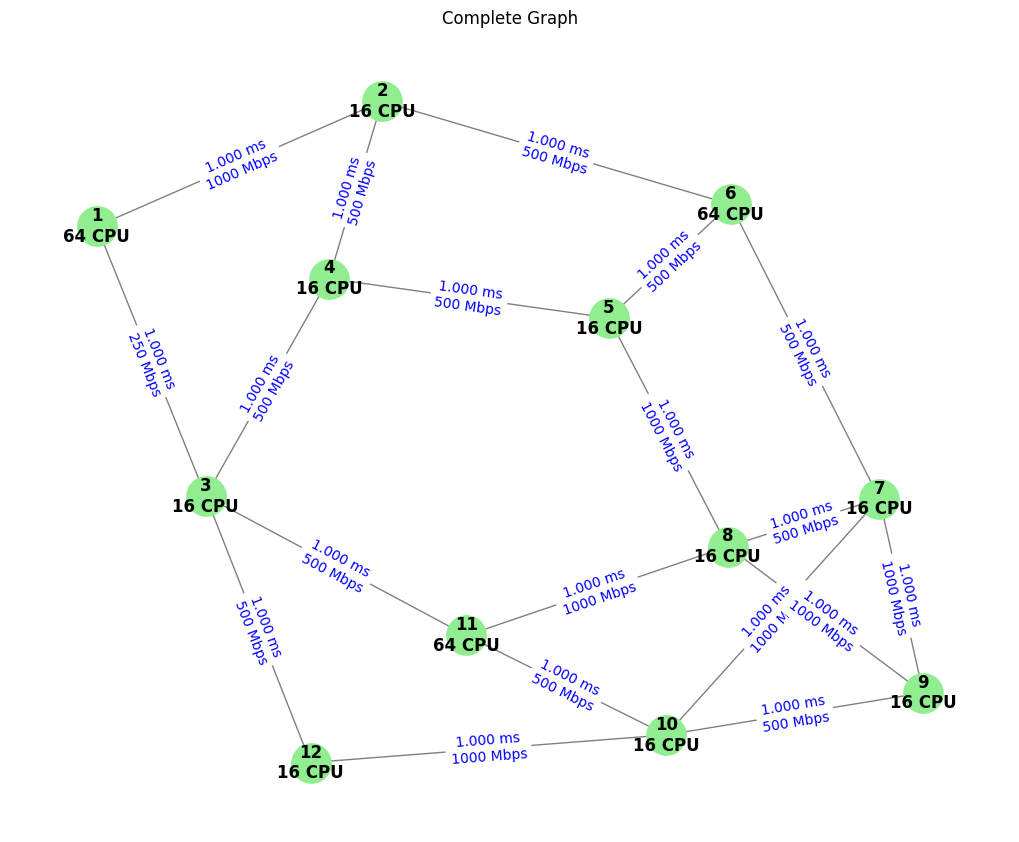

In [1]:
from topology import topology_bayern, draw_graph, topologie_finlande
from generate_slices import generate_random_slices
from milp.topology_to_instance import build_instance_from_topology
from milp.solver_gurobi import solve_gurobi      
from milp.adapter import MILPResultAdapterGurobi

import pandas as pd

# === Topology ===
G = topologie_finlande()
draw_graph(G)


In [27]:

from generate_slices import generate_random_slices
ENTRY_NODE = 2
EXIT_NODE = 9
# === Define corridor in the topology ===
vnf_profiles = [
    {"cpu": 2, "throughput": 140, "latency": 120},
    {"cpu": 4, "throughput": 150, "latency": 180},
    {"cpu": 6, "throughput": 160, "latency": 200},
    {"cpu": 8, "throughput": 175, "latency": 250}
]
# === Generate slices ===
slices = generate_random_slices(G, vnf_profiles, num_slices=10, num_vnfs_per_slice=3, entry=ENTRY_NODE, exit_=EXIT_NODE)
slices

[([{'cpu': 2, 'throughput': 140, 'latency': 120, 'id': 'vnf0_0', 'slice': 0},
   {'cpu': 4, 'throughput': 150, 'latency': 180, 'id': 'vnf0_1', 'slice': 0},
   {'cpu': 6, 'throughput': 160, 'latency': 200, 'id': 'vnf0_2', 'slice': 0}],
  [{'from': 'vnf0_0', 'to': 'vnf0_1', 'bandwidth': 140, 'latency': 120},
   {'from': 'vnf0_1', 'to': 'vnf0_2', 'bandwidth': 150, 'latency': 180}],
  2,
  9),
 ([{'cpu': 2, 'throughput': 140, 'latency': 120, 'id': 'vnf1_0', 'slice': 1},
   {'cpu': 4, 'throughput': 150, 'latency': 180, 'id': 'vnf1_1', 'slice': 1},
   {'cpu': 6, 'throughput': 160, 'latency': 200, 'id': 'vnf1_2', 'slice': 1}],
  [{'from': 'vnf1_0', 'to': 'vnf1_1', 'bandwidth': 140, 'latency': 120},
   {'from': 'vnf1_1', 'to': 'vnf1_2', 'bandwidth': 150, 'latency': 180}],
  2,
  9),
 ([{'cpu': 2, 'throughput': 140, 'latency': 120, 'id': 'vnf2_0', 'slice': 2},
   {'cpu': 4, 'throughput': 150, 'latency': 180, 'id': 'vnf2_1', 'slice': 2},
   {'cpu': 6, 'throughput': 160, 'latency': 200, 'id': 'vn

In [28]:

node_capacity_base = {n: G.nodes[n]["cpu"] for n in G.nodes}

link_capacity_base = {(u, v): G[u][v]["bandwidth"] for u, v in G.edges}
link_capacity_base.update({(v, u): G[u][v]["bandwidth"] for u, v in G.edges})

link_latency = {(u, v): G[u][v]["latency"] for u, v in G.edges}
link_latency.update({(v, u): G[u][v]["latency"] for u, v in G.edges})


In [29]:
# === Run heuristics inside the corridor ===
from a_star import run_astar
from best_fit import run_best_fit
from first_fit import run_first_fit
from run_abo_full_batch import run_abo_full_batch
from run_fabo_full_batch import run_fabo_full_batch

df_astar, results_astar = run_astar(G, slices, node_capacity_base, link_capacity_base)
df_abo, abo_results = run_abo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_fabo, fabo_results = run_fabo_full_batch(G, slices, node_capacity_base, link_latency, link_capacity_base)
df_ff, ff_results = run_first_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)
df_bestfit, bestfit_results = run_best_fit(G, slices, node_capacity_base, link_capacity_base, link_latency)


# === Display results ===
display(df_astar)
display(df_ff)
display(df_abo)
display(df_fabo)
display(df_bestfit)


[INFO][A*] === Solving slice 1 (VNFs=3, VLs=2) ===
[INFO][A*] Placed vnf0_0 on node 1 (CPU used=2, remaining=62).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 1]
[INFO][A*] Placed vnf0_0 on node 6 (CPU used=2, remaining=62).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 6]
[INFO][A*] Placed vnf0_0 on node 11 (CPU used=2, remaining=62).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 1, 3, 11]
[INFO][A*] Placed vnf0_0 on node 2 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2]
[INFO][A*] Placed vnf0_0 on node 3 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 1, 3]
[INFO][A*] Placed vnf0_0 on node 4 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 4]
[INFO][A*] Placed vnf0_0 on node 5 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 4, 5]
[INFO][A*] Placed vnf0_0 on node 7 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 6, 7]
[INFO][A*] Placed vnf0_0 on node 8 (CPU used=2, remaining=14).
[INFO][A*] Routed ENTRY->vnf0_0: [2, 4, 5, 8]
[

slice  accepted  g_cost
0      1      True     3.0
1      2      True     3.0
2      3      True     3.0
3      4      True     4.0
4      5      True     4.0
5      6      True     4.0
6      7      True     5.0
7      8     False     NaN
8      9     False     NaN
9     10     False     NaN

slice  accepted  g_cost
0      1      True     7.0
1      2      True     6.0
2      3      True     6.0
3      4      True     6.0
4      5      True     6.0
5      6      True     5.0
6      7      True     7.0
7      8     False     NaN
8      9     False     NaN
9     10     False     NaN

slice  accepted  g_cost
0      1      True     3.0
1      2      True     3.0
2      3      True     3.0
3      4      True     4.0
4      5      True     4.0
5      6      True     4.0
6      7      True     5.0
7      8     False     NaN
8      9     False     NaN
9     10     False     NaN

slice  accepted  g_cost
0      1      True     3.0
1      2      True     3.0
2      3      True     3.0
3      4      True     4.0
4      5      True     4.0
5      6      True     4.0
6      7      True     5.0
7      8     False     NaN
8      9     False     NaN
9     10     False     NaN

slice  accepted  g_cost
0      1      True     6.0
1      2      True     7.0
2      3      True     5.0
3      4      True     5.0
4      5      True     6.0
5      6     False     NaN
6      7     False     NaN
7      8     False     NaN
8      9     False     NaN
9     10     False     NaN

In [30]:
# All comments in English
import matplotlib.pyplot as plt
import networkx as nx

def plot_solution_heuristic(G, result, title="Heuristic Solution", pos=None):
    """
    Visualize the solution of a heuristic algorithm.
    - Active nodes in green if hosting at least one VNF
    - Each routed virtual link path drawn in a distinct color
    - Entry/exit legs drawn as dashed black lines
    - Node labels show VNFs placed
    - Path details printed in console
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    vnfs_per_node = {n: [] for n in G.nodes()}
    if hasattr(result, "placed_vnfs"):
        for vnf, n in result.placed_vnfs.items():
            vnfs_per_node[n].append(vnf)

    active_nodes = {n for n, lst in vnfs_per_node.items() if lst}
    node_colors = ["lightgreen" if n in active_nodes else "lightgray" for n in G.nodes()]

    plt.figure(figsize=(9, 7))
    nx.draw(G, pos, node_color=node_colors, node_size=800, with_labels=True, font_size=9)

    if not result or not hasattr(result, "routed_vls") or not result.routed_vls:
        print("No routed virtual links found in result.")
        plt.title(title)
        plt.show()
        return

    colors = plt.cm.tab10.colors
    for idx, ((src, dst), path) in enumerate(result.routed_vls.items()):
        color = colors[idx % len(colors)]
        edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        mid_idx = len(path) // 2
        mid_node = path[mid_idx]

        # Entry/Exit paths in dashed black
        if src == "ENTRY" or dst == "EXIT":
            nx.draw_networkx_edges(G, pos, edgelist=edges_in_path, edge_color="black",
                                   style="dashed", width=2, alpha=0.9)
            label = "ENTRY→first" if src == "ENTRY" else "last→EXIT"
            plt.text(pos[mid_node][0], pos[mid_node][1] + 0.08, label, color="black", fontsize=7)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=edges_in_path,
                                   edge_color=[color], width=3, alpha=0.9)
            plt.text(pos[mid_node][0], pos[mid_node][1] + 0.05,
                     f"{src}->{dst}", color=color, fontsize=8)

        print(f"Path for VL {src}->{dst}: {path}")

    plt.title(title)
    plt.show()


In [39]:
def plot_all_routes(G, results, title="All Routed Paths (All Slices)"):
    import matplotlib.pyplot as plt
    import networkx as nx
    import random

    # --- Layout ---
    pos = nx.spring_layout(G, seed=42, k=0.8)
    plt.figure(figsize=(12, 9))

    # === Base topology (black background) ===
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color="white",
        edgecolors="black",
        node_size=850,
        linewidths=1.8,
        alpha=1.0,
    )
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color="black",
        width=1.2,
        style="solid",
        alpha=0.4,
    )
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold", font_color="black")

    # === Color palette (strong contrast) ===
    cmap = (
        list(plt.cm.tab10.colors)
        + list(plt.cm.Set2.colors)
        + list(plt.cm.Dark2.colors)
        + list(plt.cm.Paired.colors)
    )

    # === Plot each slice route ===
    color_idx = 0
    used_labels = set()
    label_offset_factor = 0.05

    for s_idx, res in enumerate(results):
        if not res or not hasattr(res, "routed_vls"):
            continue

        for (src, dst), path in res.routed_vls.items():
            edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
            color = cmap[color_idx % len(cmap)]
            color_idx += 1

            # Draw route edges over black background
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=edges_in_path,
                edge_color=[color],
                width=3.0,
                alpha=0.9,
            )

            # --- Label positioning ---
            mid_idx = len(path) // 2
            mid_node = path[mid_idx]
            x, y = pos[mid_node]
            offset_x = random.uniform(-0.04, 0.04)
            offset_y = label_offset_factor * ((color_idx % 5) - 2)
            label_text = f"S{s_idx + 1}: {src}->{dst}"

            if label_text not in used_labels:
                plt.text(
                    x + offset_x,
                    y + offset_y,
                    label_text,
                    color=color,
                    fontsize=8,
                    fontweight="bold",
                    bbox=dict(
                        facecolor="white",
                        alpha=0.8,
                        edgecolor="none",
                        boxstyle="round,pad=0.15",
                    ),
                )
                used_labels.add(label_text)

            print(f"[Slice {s_idx+1}] Path {src}->{dst}: {path}")

    plt.title(title, fontsize=14, fontweight="bold", pad=15)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


[Slice 1] Path ENTRY->vnf0_0: [2]
[Slice 1] Path vnf0_0->vnf0_1: [2, 6]
[Slice 1] Path vnf0_1->vnf0_2: [6, 7]
[Slice 1] Path vnf0_2->EXIT: [7, 9]
[Slice 2] Path ENTRY->vnf1_0: [2]
[Slice 2] Path vnf1_0->vnf1_1: [2, 6]
[Slice 2] Path vnf1_1->vnf1_2: [6, 7, 9]
[Slice 2] Path vnf1_2->EXIT: [9]
[Slice 3] Path ENTRY->vnf2_0: [2]
[Slice 3] Path vnf2_0->vnf2_1: [2, 6]
[Slice 3] Path vnf2_1->vnf2_2: [6, 7]
[Slice 3] Path vnf2_2->EXIT: [7, 9]
[Slice 4] Path ENTRY->vnf3_0: [2]
[Slice 4] Path vnf3_0->vnf3_1: [2, 4]
[Slice 4] Path vnf3_1->vnf3_2: [4, 5]
[Slice 4] Path vnf3_2->EXIT: [5, 8, 9]
[Slice 5] Path ENTRY->vnf4_0: [2]
[Slice 5] Path vnf4_0->vnf4_1: [2, 4]
[Slice 5] Path vnf4_1->vnf4_2: [4, 5, 8]
[Slice 5] Path vnf4_2->EXIT: [8, 9]
[Slice 6] Path ENTRY->vnf5_0: [2]
[Slice 6] Path vnf5_0->vnf5_1: [2, 4]
[Slice 6] Path vnf5_1->vnf5_2: [4, 5]
[Slice 6] Path vnf5_2->EXIT: [5, 8, 9]
[Slice 7] Path ENTRY->vnf6_0: [2]
[Slice 7] Path vnf6_0->vnf6_1: [2, 1]
[Slice 7] Path vnf6_1->vnf6_2: [1, 3, 11]
[

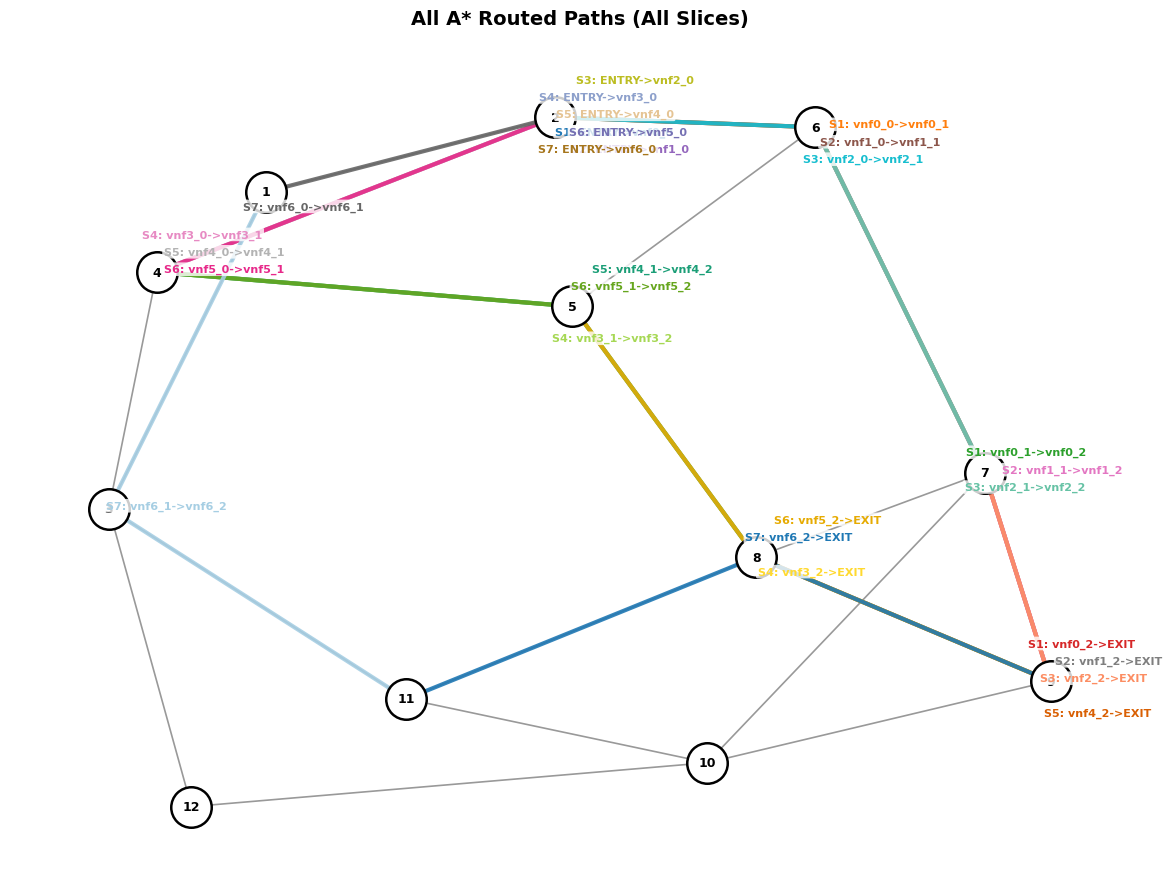

In [40]:
plot_all_routes(G, results_astar, title="All A* Routed Paths (All Slices)")


[Slice 1] Path ENTRY->vnf0_0: [2]
[Slice 1] Path vnf0_0->vnf0_1: [2, 1, 3]
[Slice 1] Path vnf0_1->vnf0_2: [3, 4]
[Slice 1] Path vnf0_2->EXIT: [4, 5, 8, 9]
[Slice 2] Path ENTRY->vnf1_0: [2, 4]
[Slice 2] Path vnf1_0->vnf1_1: [4, 3]
[Slice 2] Path vnf1_1->vnf1_2: [3, 1, 2]
[Slice 2] Path vnf1_2->EXIT: [2, 6, 7, 9]
[Slice 3] Path ENTRY->vnf2_0: [2]
[Slice 3] Path vnf2_0->vnf2_1: [2, 4]
[Slice 3] Path vnf2_1->vnf2_2: [4, 3]
[Slice 3] Path vnf2_2->EXIT: [3, 11, 8, 9]
[Slice 4] Path ENTRY->vnf3_0: [2, 4]
[Slice 4] Path vnf3_0->vnf3_1: [4, 2]
[Slice 4] Path vnf3_1->vnf3_2: [2, 6, 7]
[Slice 4] Path vnf3_2->EXIT: [7, 9]
[Slice 5] Path ENTRY->vnf4_0: [2]
[Slice 5] Path vnf4_0->vnf4_1: [2, 6, 7]
[Slice 5] Path vnf4_1->vnf4_2: [7, 6, 5]
[Slice 5] Path vnf4_2->EXIT: [5, 8, 9]


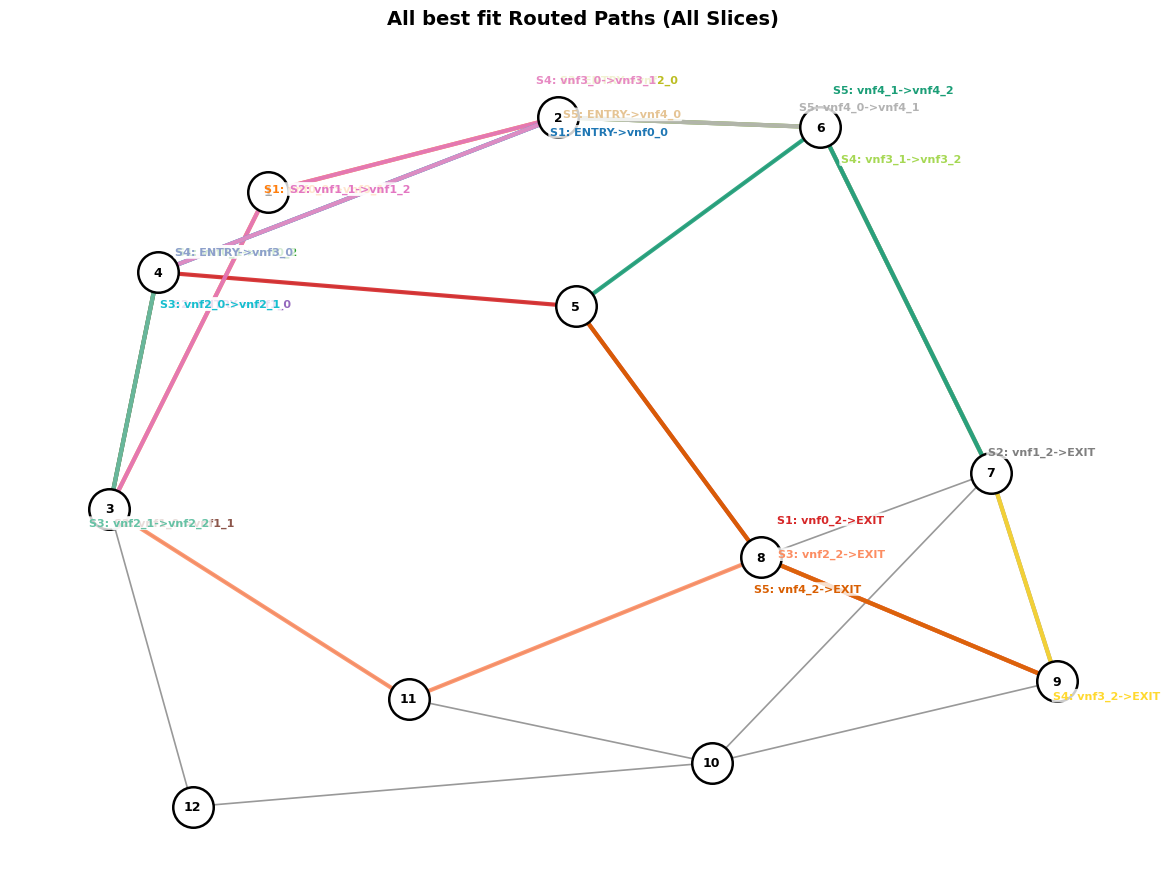

In [41]:
plot_all_routes(G, bestfit_results, title="All best fit Routed Paths (All Slices)")

[Slice 1] Path ENTRY->vnf0_0: [2, 1]
[Slice 1] Path vnf0_0->vnf0_1: [1, 2]
[Slice 1] Path vnf0_1->vnf0_2: [2, 1, 3]
[Slice 1] Path vnf0_2->EXIT: [3, 11, 8, 9]
[Slice 2] Path ENTRY->vnf1_0: [2, 1]
[Slice 2] Path vnf1_0->vnf1_1: [1, 2]
[Slice 2] Path vnf1_1->vnf1_2: [2, 4]
[Slice 2] Path vnf1_2->EXIT: [4, 5, 8, 9]
[Slice 3] Path ENTRY->vnf2_0: [2, 1]
[Slice 3] Path vnf2_0->vnf2_1: [1, 2]
[Slice 3] Path vnf2_1->vnf2_2: [2, 4]
[Slice 3] Path vnf2_2->EXIT: [4, 5, 8, 9]
[Slice 4] Path ENTRY->vnf3_0: [2, 1]
[Slice 4] Path vnf3_0->vnf3_1: [1, 2]
[Slice 4] Path vnf3_1->vnf3_2: [2, 4, 5]
[Slice 4] Path vnf3_2->EXIT: [5, 8, 9]
[Slice 5] Path ENTRY->vnf4_0: [2, 1]
[Slice 5] Path vnf4_0->vnf4_1: [1, 2, 6]
[Slice 5] Path vnf4_1->vnf4_2: [6, 5]
[Slice 5] Path vnf4_2->EXIT: [5, 8, 9]
[Slice 6] Path ENTRY->vnf5_0: [2, 1]
[Slice 6] Path vnf5_0->vnf5_1: [1, 2, 6]
[Slice 6] Path vnf5_1->vnf5_2: [6, 7]
[Slice 6] Path vnf5_2->EXIT: [7, 9]
[Slice 7] Path ENTRY->vnf6_0: [2, 6]
[Slice 7] Path vnf6_0->vnf6_1: [

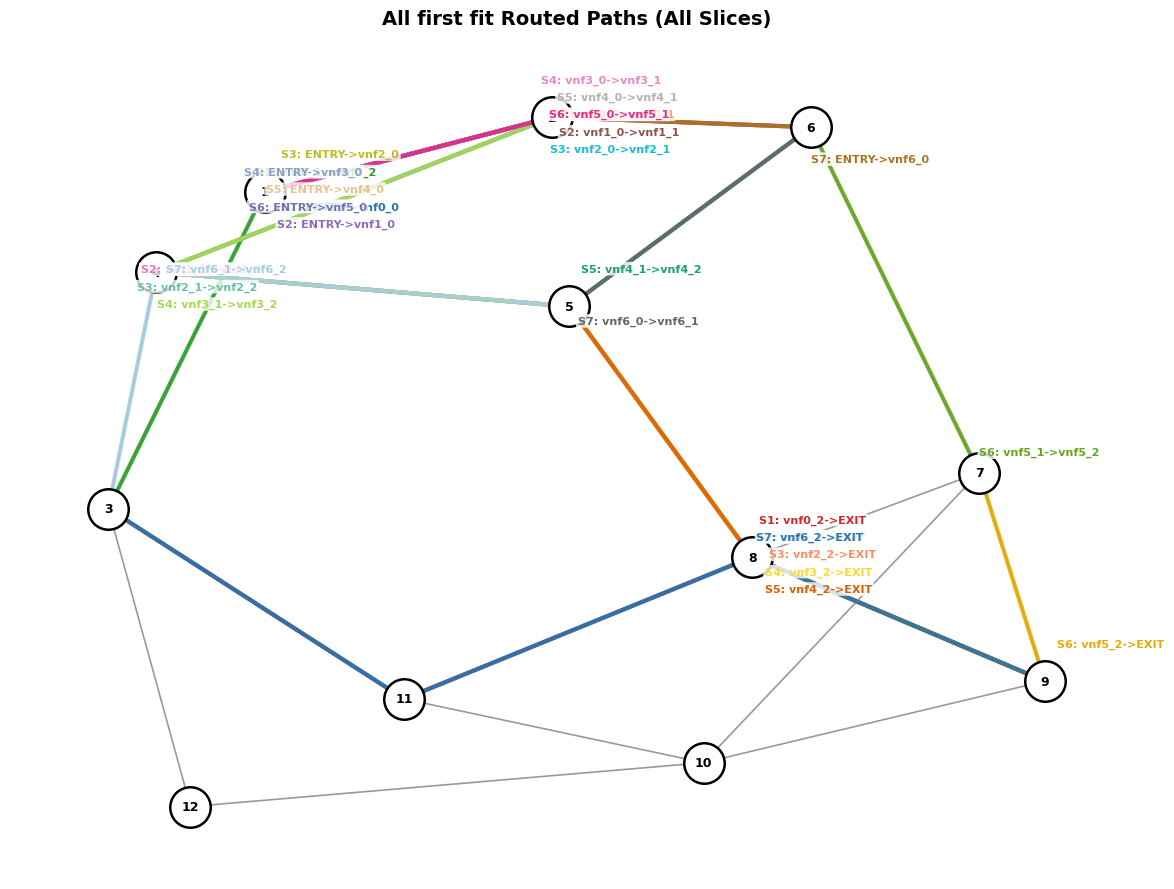

In [42]:
plot_all_routes(G, ff_results, title="All first fit Routed Paths (All Slices)")

[Slice 1] Path ENTRY->vnf0_0: [2]
[Slice 1] Path vnf0_0->vnf0_1: [2, 6]
[Slice 1] Path vnf0_1->vnf0_2: [6, 7]
[Slice 1] Path vnf0_2->EXIT: [7, 9]
[Slice 2] Path ENTRY->vnf1_0: [2]
[Slice 2] Path vnf1_0->vnf1_1: [2, 6]
[Slice 2] Path vnf1_1->vnf1_2: [6, 7]
[Slice 2] Path vnf1_2->EXIT: [7, 9]
[Slice 3] Path ENTRY->vnf2_0: [2]
[Slice 3] Path vnf2_0->vnf2_1: [2, 6]
[Slice 3] Path vnf2_1->vnf2_2: [6, 7, 9]
[Slice 3] Path vnf2_2->EXIT: [9]
[Slice 4] Path ENTRY->vnf3_0: [2]
[Slice 4] Path vnf3_0->vnf3_1: [2, 4]
[Slice 4] Path vnf3_1->vnf3_2: [4, 5]
[Slice 4] Path vnf3_2->EXIT: [5, 8, 9]
[Slice 5] Path ENTRY->vnf4_0: [2]
[Slice 5] Path vnf4_0->vnf4_1: [2, 4]
[Slice 5] Path vnf4_1->vnf4_2: [4, 5]
[Slice 5] Path vnf4_2->EXIT: [5, 8, 9]
[Slice 6] Path ENTRY->vnf5_0: [2]
[Slice 6] Path vnf5_0->vnf5_1: [2, 4]
[Slice 6] Path vnf5_1->vnf5_2: [4, 5, 8]
[Slice 6] Path vnf5_2->EXIT: [8, 9]
[Slice 7] Path ENTRY->vnf6_0: [2]
[Slice 7] Path vnf6_0->vnf6_1: [2, 1]
[Slice 7] Path vnf6_1->vnf6_2: [1, 3]
[Slic

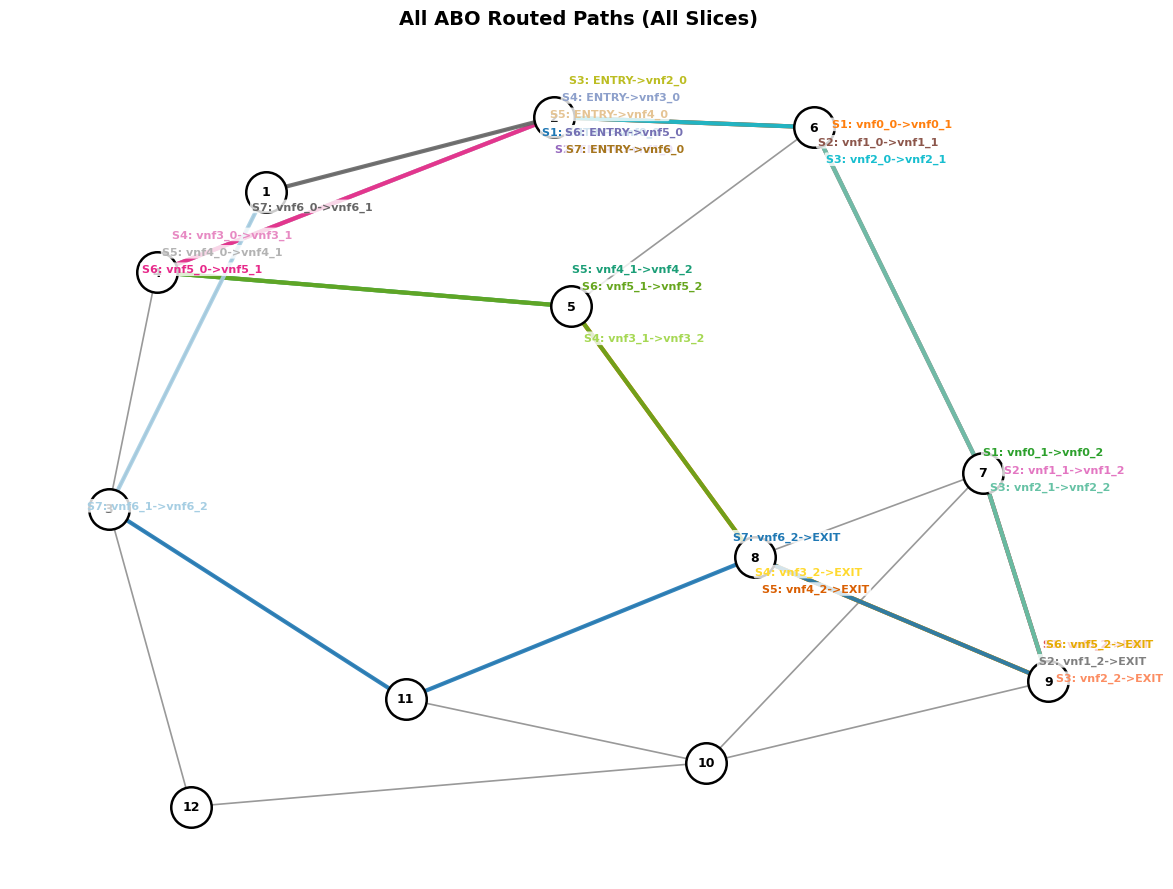

In [43]:
plot_all_routes(G, abo_results, title="All ABO Routed Paths (All Slices)")

[Slice 1] Path ENTRY->vnf0_0: [2]
[Slice 1] Path vnf0_0->vnf0_1: [2, 6]
[Slice 1] Path vnf0_1->vnf0_2: [6, 7]
[Slice 1] Path vnf0_2->EXIT: [7, 9]
[Slice 2] Path ENTRY->vnf1_0: [2]
[Slice 2] Path vnf1_0->vnf1_1: [2, 6]
[Slice 2] Path vnf1_1->vnf1_2: [6, 7, 9]
[Slice 2] Path vnf1_2->EXIT: [9]
[Slice 3] Path ENTRY->vnf2_0: [2]
[Slice 3] Path vnf2_0->vnf2_1: [2, 6]
[Slice 3] Path vnf2_1->vnf2_2: [6, 7]
[Slice 3] Path vnf2_2->EXIT: [7, 9]
[Slice 4] Path ENTRY->vnf3_0: [2]
[Slice 4] Path vnf3_0->vnf3_1: [2, 4]
[Slice 4] Path vnf3_1->vnf3_2: [4, 5]
[Slice 4] Path vnf3_2->EXIT: [5, 8, 9]
[Slice 5] Path ENTRY->vnf4_0: [2]
[Slice 5] Path vnf4_0->vnf4_1: [2, 4]
[Slice 5] Path vnf4_1->vnf4_2: [4, 5, 8]
[Slice 5] Path vnf4_2->EXIT: [8, 9]
[Slice 6] Path ENTRY->vnf5_0: [2]
[Slice 6] Path vnf5_0->vnf5_1: [2, 4]
[Slice 6] Path vnf5_1->vnf5_2: [4, 5]
[Slice 6] Path vnf5_2->EXIT: [5, 8, 9]
[Slice 7] Path ENTRY->vnf6_0: [2]
[Slice 7] Path vnf6_0->vnf6_1: [2, 1]
[Slice 7] Path vnf6_1->vnf6_2: [1, 3]
[Slic

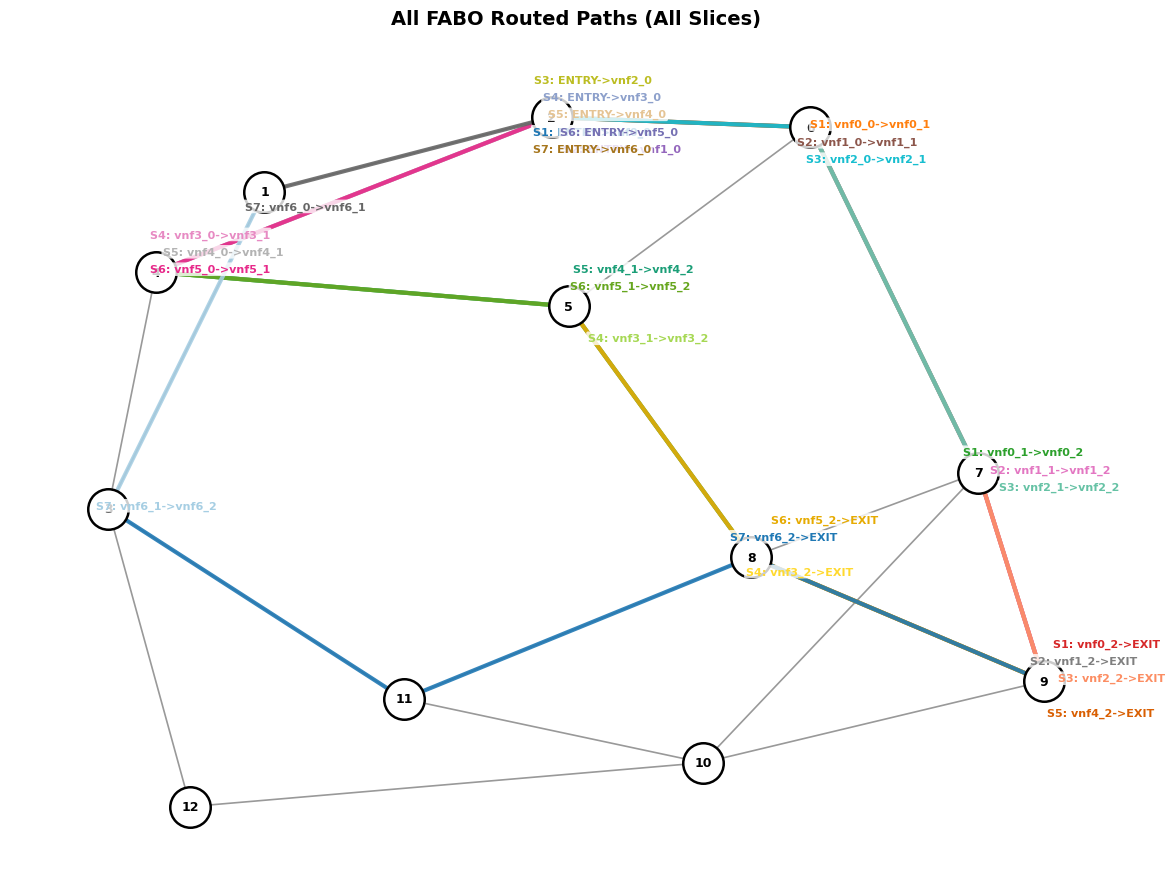

In [44]:
plot_all_routes(G, fabo_results, title="All FABO Routed Paths (All Slices)")

In [45]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=False):
    """
    Count accepted slices across different result types:
      - All VNFs placed
      - All VLs routed

    Handles:
      (A) Heuristics → list with one result per slice (has .placed_vnfs / .routed_vls)
      (B) MILP adapter (CBC or Gurobi) → single aggregated result with routed_vls keys like (s_idx, (src, dst))
      (C) Raw solver result (PulpSolveResult or GurobiSolveResult) → single result with .values dict
    """
    if not results:
        return 0

    # --- Helper: check routed VL presence with multiple key styles
    def _vl_present(routed_vls, s_idx, src, dst):
        """Check several key conventions: (src,dst), (dst,src), (s,(src,dst)), (s,(dst,src))."""
        if (src, dst) in routed_vls or (dst, src) in routed_vls:
            return True
        key1 = (s_idx, (src, dst))
        key2 = (s_idx, (dst, src))
        return key1 in routed_vls or key2 in routed_vls

    # ----------------------
    # Case C: raw solver result (PuLP or Gurobi)
    # ----------------------
    r0 = results[0]
    if hasattr(r0, "values"):  # works for PulpSolveResult or GurobiSolveResult
        var_dict = r0.values
        accepted = 0
        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            # --- VNFs placed ---
            vnfs_ok = True
            for v in vnfs:
                i = v["id"]
                assigned = any(
                    isinstance(k, tuple) and k[0] == "v" and k[1] == i and val > 0.5
                    for k, val in var_dict.items()
                )
                if not assigned:
                    vnfs_ok = False
                    if verbose:
                        print(f"[MILP raw] slice {s_idx}: VNF {i} not allocated")
                    break

            # --- VLs routed ---
            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    routed = any(
                        isinstance(k, tuple)
                        and k[0] == "f"
                        and k[2] == s_idx
                        and set(k[3]) == {src, dst}
                        and val > 0.5
                        for k, val in var_dict.items()
                    )
                    if not routed:
                        vls_ok = False
                        if verbose:
                            print(f"[MILP raw] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP raw] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP raw): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case B: MILP adapter (CBC or Gurobi)
    # ----------------------
    is_milp_adapter = (
        len(results) == 1
        and hasattr(r0, "routed_vls")
        and any(isinstance(k, tuple) and len(k) >= 2 and isinstance(k[0], int)
                for k in r0.routed_vls.keys())
    )
    if is_milp_adapter:
        accepted = 0
        placed_vnfs = getattr(r0, "placed_vnfs", {})
        routed_vls = getattr(r0, "routed_vls", {})

        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]
            vnfs_ok = all(v["id"] in placed_vnfs for v in vnfs)

            if not vnfs_ok and verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in placed_vnfs]
                print(f"[MILP adapter] slice {s_idx}: missing VNFs {missing}")

            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    if not _vl_present(routed_vls, s_idx, src, dst):
                        vls_ok = False
                        if verbose:
                            print(f"[MILP adapter] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP adapter] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP adapter): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case A: heuristics (one result per slice)
    # ----------------------
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            continue
        vnfs, vls = slices[s_idx]

        vnfs_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not vnfs_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Heuristic] slice {s_idx}: missing VNFs {missing}")
            continue

        vls_ok = all(
            (vl["from"], vl["to"]) in result.routed_vls or (vl["to"], vl["from"]) in result.routed_vls
            for vl in vls
        )
        if not vls_ok and verbose:
            missing = [
                (vl["from"], vl["to"]) for vl in vls
                if (vl["from"], vl["to"]) not in result.routed_vls
                and (vl["to"], vl["from"]) not in result.routed_vls
            ]
            print(f"[Heuristic] slice {s_idx}: missing VLs {missing}")

        if vnfs_ok and vls_ok:
            accepted += 1
            if verbose:
                print(f"[Heuristic] slice {s_idx}: ACCEPTED ✓")

    if verbose:
        print(f"Total slices accepted (heuristics): {accepted}/{len(results)}")
    return accepted


In [46]:
# === Build MILP instance that supports (vnf_chain, vl_chain) or (vnf_chain, vl_chain, entry, exit_) ===
from types import SimpleNamespace

def create_instance(G, slices):
    """
    Build a minimal MILP-compatible instance object from graph G and slices.
    Supports slices with or without ENTRY/EXIT info.
    """
    instance = SimpleNamespace()

    # --- Basic sets ---
    instance.N = list(G.nodes)
    instance.E = list(G.edges)
    instance.S = list(range(len(slices)))

    # --- Link attributes ---
    instance.lat_e = {(u, v): G[u][v].get("latency", 1.0) for u, v in G.edges}
    instance.BW_cap = {(u, v): G[u][v].get("bandwidth", 100.0) for u, v in G.edges}

    # --- Node capacities ---
    instance.CPU_cap = {n: G.nodes[n].get("cpu", 100.0) for n in G.nodes}

    # --- Slice data structures ---
    instance.V_of_s = {}
    instance.CPU_i = {}
    instance.BW_s = {}
    instance.L_s = {}

    # Optional per-slice entry/exit dictionaries
    instance.entry_of_s = {}
    instance.exit_of_s = {}

    for s_idx, slice_data in enumerate(slices):
        # Accept either 2-tuple or 4-tuple
        if len(slice_data) == 2:
            vnf_chain, vl_chain = slice_data
            entry = None
            exit_ = None
        elif len(slice_data) == 4:
            vnf_chain, vl_chain, entry, exit_ = slice_data
            instance.entry_of_s[s_idx] = entry
            instance.exit_of_s[s_idx] = exit_
        else:
            raise ValueError(f"Unexpected slice structure: {len(slice_data)} elements")

        # Register VNFs
        vnf_ids = [vnf["id"] for vnf in vnf_chain]
        instance.V_of_s[s_idx] = vnf_ids

        # CPU requirements
        for vnf in vnf_chain:
            instance.CPU_i[vnf["id"]] = vnf["cpu"]

        # Bandwidth = média dos VLs (ou 0 se não houver)
        if vl_chain:
            bw_avg = sum(vl["bandwidth"] for vl in vl_chain) / len(vl_chain)
            lat_max = max(vl["latency"] for vl in vl_chain)
        else:
            bw_avg = 0.0
            lat_max = 0.0

        instance.BW_s[s_idx] = bw_avg
        instance.L_s[s_idx] = lat_max

    # Caso não haja ENTRY/EXIT por slice, define globais padrão
    instance.entry_node = 2
    instance.exit_node = 9

    return instance


Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 763 rows, 1182 columns and 6053 nonzeros
Model fingerprint: 0xd7d26ae4
Variable types: 31 continuous, 1151 integer (1151 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 477 rows and 816 columns
Presolve time: 0.02s
Presolved: 286 rows, 366 columns, 1522 nonzeros
Variable types: 0 continuous, 366 integer (366 binary)

Root relaxation: infeasible, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

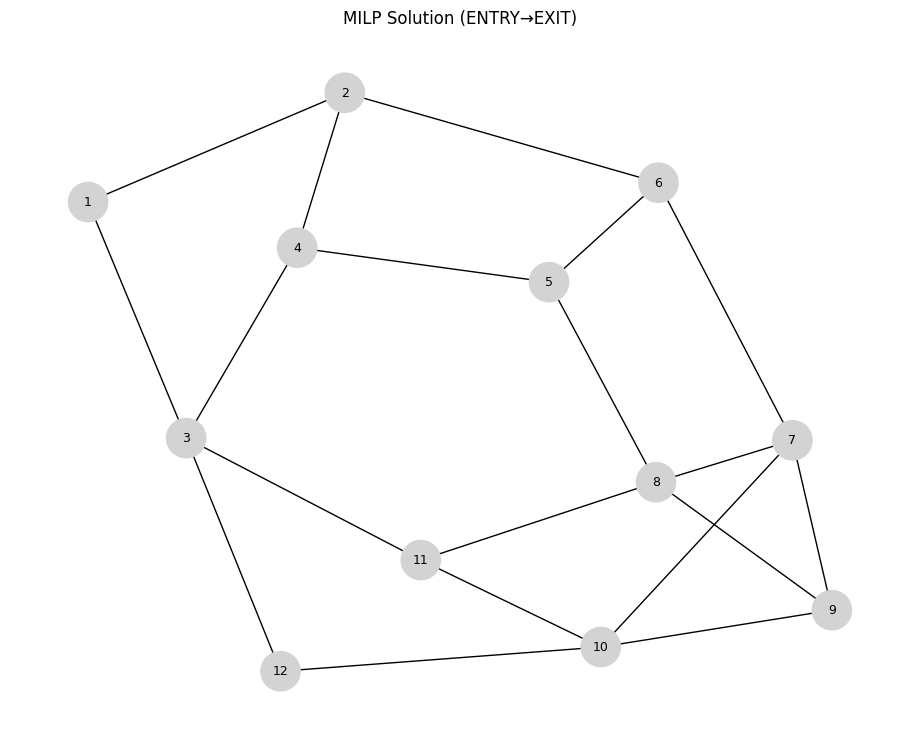

In [47]:
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

# === 1. Criar instance ===
instance = create_instance(G, slices)
instance.entry_node = 2
instance.exit_node = 9

# === 2. Rodar o MILP ===
milp_res = solve_gurobi(instance, msg=True, time_limit=120)
# === 3. Adaptar e visualizar ===
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
print(milp_adapter) 

plot_solution_heuristic(G, milp_adapter, title="MILP Solution (ENTRY→EXIT)")


Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 763 rows, 1182 columns and 6053 nonzeros
Model fingerprint: 0xd7d26ae4
Variable types: 31 continuous, 1151 integer (1151 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 477 rows and 816 columns
Presolve time: 0.01s
Presolved: 286 rows, 366 columns, 1522 nonzeros
Variable types: 0 continuous, 366 integer (366 binary)

Root relaxation: infeasible, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

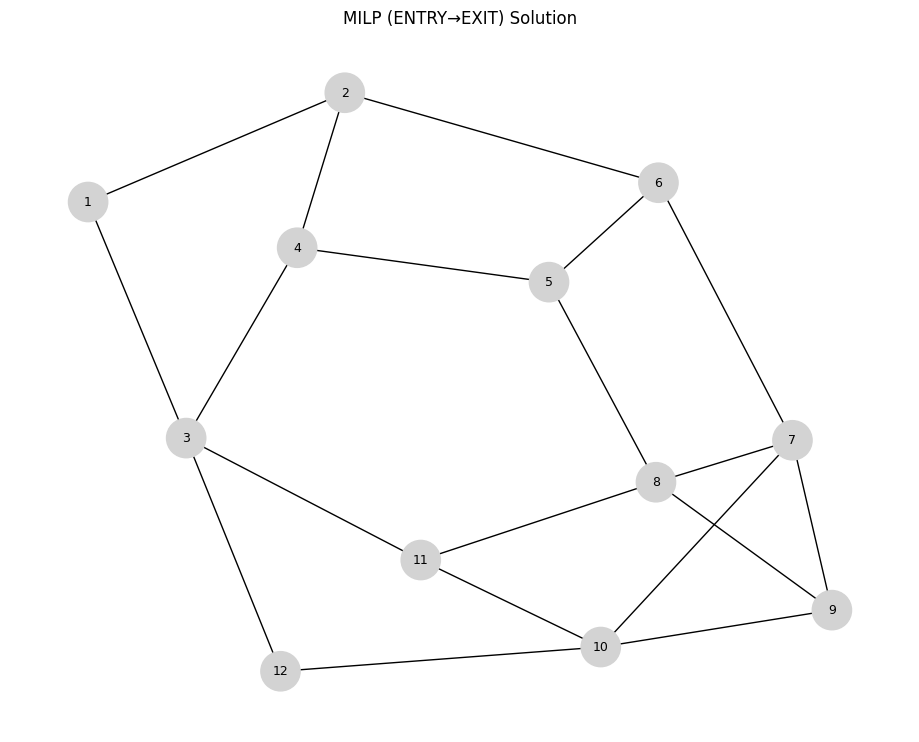

In [48]:
# === 1. Build instance ===
instance = create_instance(G, slices)

# === 2. Solve MILP ===
from milp.solver_gurobi import solve_gurobi
milp_res = solve_gurobi(instance, msg=True, time_limit=60)

# === 3. Adapt and visualize ===
from milp.adapter import MILPResultAdapterGurobi
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)
plot_solution_heuristic(G, milp_adapter, title="MILP (ENTRY→EXIT) Solution")


In [49]:
def count_accepted_slices(results, slices, eps=1e-6, verbose=False):
    """
    Count accepted slices across different result types:
      - All VNFs placed
      - All VLs routed

    Handles:
      (A) Heuristics → list with one result per slice (has .placed_vnfs / .routed_vls)
      (B) MILP adapter (CBC or Gurobi) → single aggregated result with routed_vls keys like (s_idx, (src, dst))
      (C) Raw solver result (PulpSolveResult or GurobiSolveResult) → single result with .values dict
    """
    if not results:
        return 0

    # --- Helper: check routed VL presence with multiple key styles
    def _vl_present(routed_vls, s_idx, src, dst):
        """Check several key conventions: (src,dst), (dst,src), (s,(src,dst)), (s,(dst,src))."""
        if (src, dst) in routed_vls or (dst, src) in routed_vls:
            return True
        key1 = (s_idx, (src, dst))
        key2 = (s_idx, (dst, src))
        return key1 in routed_vls or key2 in routed_vls

    # ----------------------
    # Case C: raw solver result (PuLP or Gurobi)
    # ----------------------
    r0 = results[0]
    if hasattr(r0, "values"):  # works for PulpSolveResult or GurobiSolveResult
        var_dict = r0.values
        accepted = 0
        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]

            # --- VNFs placed ---
            vnfs_ok = True
            for v in vnfs:
                i = v["id"]
                assigned = any(
                    isinstance(k, tuple) and k[0] == "v" and k[1] == i and val > 0.5
                    for k, val in var_dict.items()
                )
                if not assigned:
                    vnfs_ok = False
                    if verbose:
                        print(f"[MILP raw] slice {s_idx}: VNF {i} not allocated")
                    break

            # --- VLs routed ---
            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    routed = any(
                        isinstance(k, tuple)
                        and k[0] == "f"
                        and k[2] == s_idx
                        and set(k[3]) == {src, dst}
                        and val > 0.5
                        for k, val in var_dict.items()
                    )
                    if not routed:
                        vls_ok = False
                        if verbose:
                            print(f"[MILP raw] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP raw] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP raw): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case B: MILP adapter (CBC or Gurobi)
    # ----------------------
    is_milp_adapter = (
        len(results) == 1
        and hasattr(r0, "routed_vls")
        and any(isinstance(k, tuple) and len(k) >= 2 and isinstance(k[0], int)
                for k in r0.routed_vls.keys())
    )
    if is_milp_adapter:
        accepted = 0
        placed_vnfs = getattr(r0, "placed_vnfs", {})
        routed_vls = getattr(r0, "routed_vls", {})

        for s_idx in range(len(slices)):
            vnfs, vls = slices[s_idx]
            vnfs_ok = all(v["id"] in placed_vnfs for v in vnfs)

            if not vnfs_ok and verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in placed_vnfs]
                print(f"[MILP adapter] slice {s_idx}: missing VNFs {missing}")

            vls_ok = True
            if vnfs_ok:
                for vl in vls:
                    src, dst = vl["from"], vl["to"]
                    if not _vl_present(routed_vls, s_idx, src, dst):
                        vls_ok = False
                        if verbose:
                            print(f"[MILP adapter] slice {s_idx}: VL ({src}->{dst}) not routed")
                        break

            if vnfs_ok and vls_ok:
                accepted += 1
                if verbose:
                    print(f"[MILP adapter] slice {s_idx}: ACCEPTED ✓")

        if verbose:
            print(f"Total slices accepted (MILP adapter): {accepted}/{len(slices)}")
        return accepted

    # ----------------------
    # Case A: heuristics (one result per slice)
    # ----------------------
    accepted = 0
    for s_idx, result in enumerate(results):
        if not result or not hasattr(result, "placed_vnfs") or not hasattr(result, "routed_vls"):
            continue
        vnfs, vls = slices[s_idx]

        vnfs_ok = all(v["id"] in result.placed_vnfs for v in vnfs)
        if not vnfs_ok:
            if verbose:
                missing = [v["id"] for v in vnfs if v["id"] not in result.placed_vnfs]
                print(f"[Heuristic] slice {s_idx}: missing VNFs {missing}")
            continue

        vls_ok = all(
            (vl["from"], vl["to"]) in result.routed_vls or (vl["to"], vl["from"]) in result.routed_vls
            for vl in vls
        )
        if not vls_ok and verbose:
            missing = [
                (vl["from"], vl["to"]) for vl in vls
                if (vl["from"], vl["to"]) not in result.routed_vls
                and (vl["to"], vl["from"]) not in result.routed_vls
            ]
            print(f"[Heuristic] slice {s_idx}: missing VLs {missing}")

        if vnfs_ok and vls_ok:
            accepted += 1
            if verbose:
                print(f"[Heuristic] slice {s_idx}: ACCEPTED ✓")

    if verbose:
        print(f"Total slices accepted (heuristics): {accepted}/{len(results)}")
    return accepted


In [50]:
# === Run MILP ===
from milp.solver_gurobi import solve_gurobi
from milp.adapter import MILPResultAdapterGurobi

instance = create_instance(G, slices)
milp_res = solve_gurobi(instance, msg=True, time_limit=120)
milp_adapter = MILPResultAdapterGurobi(milp_res, instance)

# === Add all methods to comparison dict ===
method_results = {
    "A*": results_astar,
    "ABO": abo_results,
    "FABO": fabo_results,
    "First Fit": ff_results,
    "Best Fit": bestfit_results,
    "MILP (Gurobi)": [milp_adapter],   # ⚠️ important: wrap in list
}


Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.2 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 11 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  120

Optimize a model with 763 rows, 1182 columns and 6053 nonzeros
Model fingerprint: 0xd7d26ae4
Variable types: 31 continuous, 1151 integer (1151 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 477 rows and 816 columns
Presolve time: 0.02s
Presolved: 286 rows, 366 columns, 1522 nonzeros
Variable types: 0 continuous, 366 integer (366 binary)

Root relaxation: infeasible, 65 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  D

In [51]:
# === Metrics and Comparison for all methods (including MILP) ===
from compute_energy import (
    compute_energy_per_node,
    compute_total_bandwidth,
    compute_total_latency,
    compute_energy_per_slice,
    compute_energy_new,
    compute_milp_bandwidth_latency
)

# --- Preprocess slices: remove entry/exit info if present ---
slices_basic = [(vnf_chain, vl_chain) if len(s) == 2 else (s[0], s[1]) for s in slices]

comparison_rows = []

for method_name, result_list in method_results.items():
    if not result_list:
        continue

    print(f"\n[INFO] === Processing metrics for {method_name} ===")

    # --- Energy metrics ---
    energy_per_slice, _ = compute_energy_per_slice(result_list, slices_basic, node_capacity_base)
    _, _ = compute_energy_per_node(result_list, slices_basic, node_capacity_base)
    normalized_energy = compute_energy_new(result_list, slices_basic, node_capacity_base, link_capacity_base)

    # --- Bandwidth & Latency ---
    total_bw = None
    total_lat = None

    try:
        if "MILP" in method_name:
            milp_adapter = result_list[0]  # single MILP adapter
            total_bw, total_lat, _, _ = compute_milp_bandwidth_latency(milp_adapter, instance)
        else:
            total_bw_list = compute_total_bandwidth(result_list, slices_basic)
            total_lat_list = compute_total_latency(result_list, link_latency)
            total_bw = sum(b for b in total_bw_list if b is not None)
            total_lat = sum(l for l in total_lat_list if l is not None)
    except Exception as e:
        print(f"[WARN] Metric computation failed for {method_name}: {e}")
        total_bw, total_lat = None, None

    # --- Build comparison row ---
    comparison_rows.append({
        "Method": method_name,
        "Slices Accepted": count_accepted_slices(result_list, slices_basic, verbose=False),
        "Total Bandwidth": total_bw,
        "Total Latency": total_lat,
        "Total Energy": normalized_energy
    })

# --- Final DataFrame ---
df_metrics = pd.DataFrame(comparison_rows).reset_index(drop=True)
display(df_metrics)



[INFO] === Processing metrics for A* ===

[INFO] === Processing metrics for ABO ===

[INFO] === Processing metrics for FABO ===

[INFO] === Processing metrics for First Fit ===

[INFO] === Processing metrics for Best Fit ===

[INFO] === Processing metrics for MILP (Gurobi) ===
[WARN] Metric computation failed for MILP (Gurobi): 'MILPResultAdapterGurobi' object has no attribute 'values'


Method  Slices Accepted  Total Bandwidth  Total Latency  \
0             A*                7           2480.0           26.0   
1            ABO                7           2330.0           26.0   
2           FABO                7           2330.0           26.0   
3      First Fit                7           2760.0           43.0   
4       Best Fit                5           2180.0           29.0   
5  MILP (Gurobi)                0              NaN            NaN   

   Total Energy  
0      13.21875  
1      13.50000  
2      13.50000  
3      11.21875  
4       8.75000  
5       0.00000